### The Project is based on **Kaggle's 2018 Data Science bowl competiton.**

###**Spot Nuclei. Speed Cures.**

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away.

So, the goal of the project is to speed up the research process for almost every disease by making a automated nucleus detection model.

### **Why Nuclues?**
Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work. Therefore by building a good nuclues detection model we are increasing efficiency of drug testing which will help shortening the time period of 1o years it takes a drug to come into market



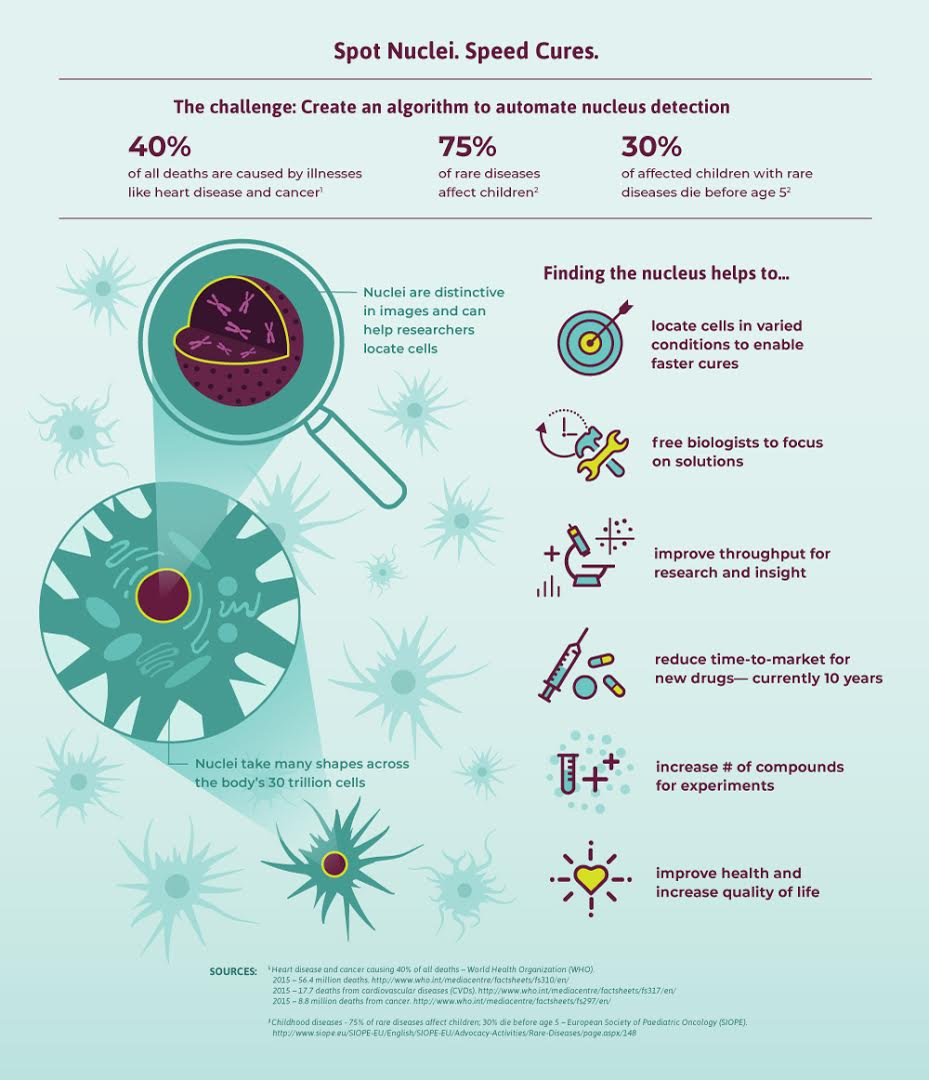

#### Dataset is taken from [Kaggle 2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/data?select=stage1_train.zip)

### About Dataset and preprocessing required

*   Dataset contains 670 folders.
*   Each folders contain another two folders named images and masks.
*   images folder contain the image taken from the microscope.
*   Most of the images of images folder are of size (256, 256) gray scale.
*   masks folder contain various number of binary images, each binary image has only one nuclei segmented.
*   We need to preprocess mask images and combine all mask into one binary image, so that we will have one output for every input image.
*   As no two masks overlaps in the dataset we can perform the above step just by taking the **pixel-wise addition** of all binary masks.
*   As majority of the images are of shape (256, 256) we need to resize every image to the same shape as CNN operates for fixed size inputs.




In [ ]:
# importing libraries

import numpy as np
import keras
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, Conv2DTranspose, Input, MaxPool2D, Concatenate
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

In [ ]:
# unzipping the data
# Dataset is preprocessed according to the steps mentioned above 
# we load the preprocessed dataset containing 670 images

!unzip '/content/images.zip'
!unzip '/content/masks.zip'

Archive:  /content/images.zip
   creating: images/
  inflating: images/0.png            
  inflating: images/1.png            
  inflating: images/10.png           
  inflating: images/100.png          
  inflating: images/101.png          
  inflating: images/102.png          
  inflating: images/103.png          
  inflating: images/104.png          
  inflating: images/105.png          
  inflating: images/106.png          
  inflating: images/107.png          
  inflating: images/108.png          
  inflating: images/109.png          
  inflating: images/11.png           
  inflating: images/110.png          
  inflating: images/111.png          
  inflating: images/112.png          
  inflating: images/113.png          
  inflating: images/114.png          
  inflating: images/115.png          
  inflating: images/116.png          
  inflating: images/117.png          
  inflating: images/118.png          
  inflating: images/119.png          
  inflating: images/12.png           

In [ ]:
x_path = '/content/images/'
y_path = '/content/masks/'

In [ ]:
# Function to read the data into numpy array
# it returns X which is an numpy array of shape (256, 256, 1) representing gray scale input image
# it also return y which is an Binary mask of the image of shape(256, 256, 1)

def get_data():
  files = os.listdir(x_path)
  X = []
  Y = []
  for f in tqdm(files):
    img = cv2.imread(x_path + f, 0)
    X.append(np.expand_dims(img, axis = -1))
    img = cv2.imread(y_path + f, 0)
    Y.append(np.expand_dims(img, axis = -1))

  return np.array(X), np.array(Y)

In [ ]:
X, y = get_data()
X = X/255.
y = y/255.

100%|██████████| 670/670 [00:00<00:00, 823.08it/s]


In [ ]:
X.shape, y.shape

((670, 256, 256, 1), (670, 256, 256, 1))

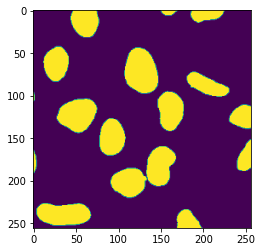

In [ ]:
# Dislaying one of the mask
plt.imshow(y[7, :, :, 0])

### **Model Building**
We use **UNet model** which was originally build for **bio-medical semantic segmentation**, the network is divided into two parts left part is called **encoder** part(contraction path) which is just normal convolution and max pool blocks, and right part which is called **Decoder** part, in decoder part we upscale the feature map using transposed convolution back to original size, also information from the encoder part is also concatanated in it.

Note we dont use various upsampling techniques like **nearest neighbour, bi-linear interpolatio**n etc, instead we use transposed convolutions with learnable parameters to learn itself to upsample, since upsampling is sparse operation we need good prior information from early stages to represent the localisation so we use skip connection from encoder part of the network

Mostly encoder part is pretrained network like **VGG/ResNet**.


## UNet architecure
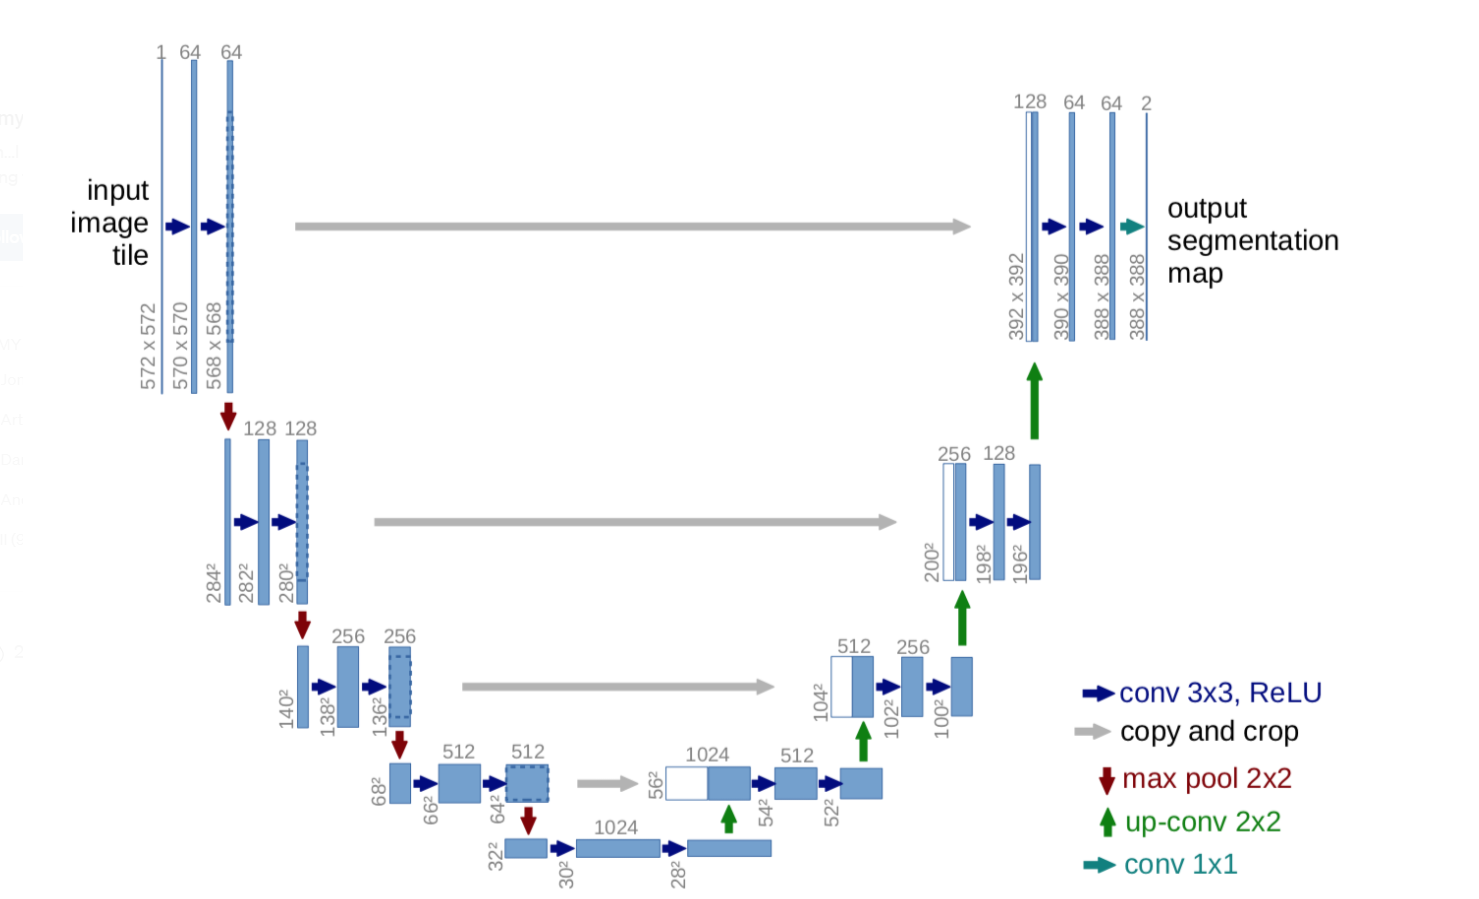

In [ ]:
# We see in every step of the network we have compulsarily two convolution layers hence lets create a function for it

def conv_block(inputs, num_filters):
  x = Conv2D(num_filters, kernel_size=3,activation = 'relu', padding = 'same')(inputs)
  x = BatchNormalization()(x)

  x = Conv2D(num_filters, kernel_size = 3, activation = 'relu', padding = 'same')(x)
  x = BatchNormalization()(x)
  return x

In [ ]:
# one encoder block contains a conv_block and a max pool layer
# output of the block is the compressed output with uncompressed output which will be feeded to decoder block

def encoder_block(inputs, num_filters):
  x = conv_block(inputs, num_filters)
  p = MaxPool2D()(x)

  return x, p

In [ ]:
# each decoder block contains a transpose convolution layer foor upsampling
# the upsampled output is concatanated with skip connection
# then again a conv_block
 
def decoder_block(input1, input2, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), activation='relu', padding='same', strides=2)(input2)
  x = Concatenate()([input1, x])

  x = conv_block(x, num_filters)

  return x

In [ ]:
def build_unet(input_shape):
  inputs = Input(input_shape)
  x1, p1 = encoder_block(inputs, num_filters=64)
  x2, p2 = encoder_block(p1, num_filters=128)
  x3, p3 = encoder_block(p2, num_filters=256)
  x4, p4 = encoder_block(p3, num_filters=512)

  b = conv_block(p4, num_filters = 1024)

  d1 = decoder_block(x4, b, num_filters=512)
  d2 = decoder_block(x3, d1, num_filters=256)
  d3 = decoder_block(x2, d2, num_filters=128)
  d4 = decoder_block(x1, d3, num_filters=64)

  outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

  model = Model(inputs, outputs)
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  model.summary()
  return model

In [ ]:
model =  build_unet(X[0].shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 69)

#### Our Dataset only contains 670 images and model has over 30 million parameters our model is highly likely to overfit and hence to reduce effect of overfitting we need to synthetically create training data, here we will use Keras' ImageDataGenerator package


In [ ]:
# New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
# This gives a binary mask rather than a mask with interpolated values
seed = 69

from keras.preprocessing.image import ImageDataGenerator

image_data_gen_args = dict(rotation_range = 90,
                           width_shift_range = 0.3,
                           height_shift_range = 0.3,
                           shear_range = 0.5,
                           zoom_range = 0.3,
                           horizontal_flip = True,
                           vertical_flip = True,
                           fill_mode = 'reflect')

mask_data_gen_args = dict(rotation_range = 90,
                           width_shift_range = 0.3,
                           height_shift_range = 0.3,
                           shear_range = 0.5,
                           zoom_range = 0.3,
                           horizontal_flip = True,
                           vertical_flip = True,
                           fill_mode = 'reflect',
                           preprocessing_function = lambda x : np.where(x>0, 1, 0).astype(x.dtype)) # Binarize the output again

batch_size = 8

image_data_generator = ImageDataGenerator(**image_data_gen_args)

image_generator = image_data_generator.flow(X_train, seed = seed, batch_size = batch_size)
valid_image_generator = image_data_generator.flow(X_test, seed = seed, batch_size = batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

mask_generator = mask_data_generator.flow(y_train, seed = seed, batch_size = batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed = seed, batch_size = batch_size)

In [ ]:
def my_image_mask_generator(image_generator, mask_generator):
  train_generator = zip(image_generator, mask_generator)

  for (img, mask) in train_generator:
    yield(img, mask)

In [ ]:
train_generator = my_image_mask_generator(image_generator, mask_generator)
valid_generator = my_image_mask_generator(valid_image_generator, valid_mask_generator)

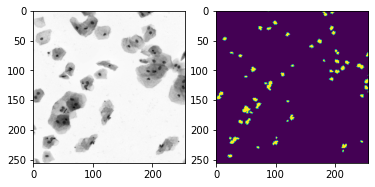

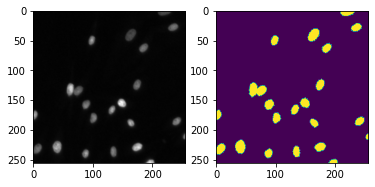

In [ ]:
x = image_generator.next() # returns 8 images (equal to batchsize)
y = mask_generator.next() # returns 8 masks (equal to batchsize) with same transfromation as images
for i in range(0,2):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
steps_per_epoch = 3*(len(X_train))//batch_size


history = model.fit_generator(train_generator, validation_data=valid_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=25)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
226/226 [==============================] - 222s 740ms/step - loss: 0.4625 - accuracy: 0.8318 - val_loss: 0.3583 - val_accuracy: 0.8366
Epoch 2/25
226/226 [==============================] - 166s 736ms/step - loss: 0.1530 - accuracy: 0.9486 - val_loss: 0.3317 - val_accuracy: 0.8694
Epoch 3/25
226/226 [==============================] - 166s 735ms/step - loss: 0.1191 - accuracy: 0.9560 - val_loss: 0.1532 - val_accuracy: 0.9336
Epoch 4/25
226/226 [==============================] - 166s 736ms/step - loss: 0.1206 - accuracy: 0.9545 - val_loss: 0.1763 - val_accuracy: 0.9355
Epoch 5/25
226/226 [==============================] - 166s 736ms/step - loss: 0.1138 - accuracy: 0.9567 - val_loss: 0.1195 - val_accuracy: 0.9562
Epoch 6/25
226/226 [==============================] - 166s 737ms/step - loss: 0.0971 - accuracy: 0.9616 - val_loss: 0.1070 - val_accuracy: 0.9578
Epoch 7/25
226/226 [==============================] - 166s 735ms/step - loss: 0.0896 - accuracy: 0.9647 - val_loss: 0.1845 -

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/semantic_segmentation/model.h5')

### Metrics
We use IoU (Intersection over union) which is a popular metric used in semantic segmentaion, it just return the common area/ total area between ever nuclei blobs, note higher IoU leads to better classification of each pixels.

We dont use categorical accuracy as most of the masks is only dark and hence a bad model which only predicts 0 will also have high accuracy and is misleading

##### Note: our model predicts a probabilty of a pixel belonging to nuclei class, hence to binarize it we need to set a threshold usually it it set to 0.5 but it is a hyperparameter we can look for.

In [ ]:
#IOU
# Here threshold is set to 0.6

y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.6

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.7913583928516008


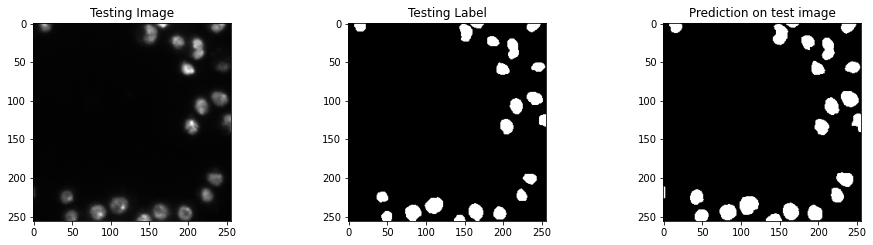

In [ ]:
test_img_number = np.random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

### **Improvemets**

*   We can use pretrained networks like VGG/ResNet as our encoder block as we don't have much traning data and transfer learning always works well with less data.
*   We should train our model by collecting a large dataset.

